<a href="https://colab.research.google.com/github/PUBPOL-2130/notebooks/blob/main/future/evictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [476]:
%config InlineBackend.figure_formats = ["retina"]

In [477]:
!pip install -q folium scikit-learn census seaborn geopandas us

In [478]:
!curl -OL https://raw.githubusercontent.com/PUBPOL-2130/notebooks/main/data/mappluto_subset.gpkg.zip
!unzip mappluto_subset.gpkg.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5857k  100 5857k    0     0  8206k      0 --:--:-- --:--:-- --:--:-- 8215k
Archive:  mappluto_subset.gpkg.zip
  inflating: mappluto_subset.gpkg    
replace __MACOSX/._mappluto_subset.gpkg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Evictions

In [ ]:
import census
import folium
import folium.plugins
import geopandas as gpd
import io
import us
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from census import Census
from shapely import Point

In [ ]:
census = Census("", year=2018)

We'll start this week with data from the [Eviction Lab](https://evictionlab.org/). This data has been assembled and compiled from multiple sources by The Eviction Lab at Princeton. More information on the methods they've used can be found [here](https://evictionlab.org/methods/). It is a powerful resource for studying eviction patterns throughout the United States.

To get a sense of what this data looks like interactively, you can explore their [interactive map](https://evictionlab.org/map).

We'll start with data for estimating eviction prevalence.

In [ ]:
df_eviction_prev = pd.read_csv(
    "https://eviction-lab-data-downloads.s3.amazonaws.com/estimating-eviction-prevalance-across-us/county_eviction_estimates_2000_2018.csv"
)
df_eviction_prev.head()

state          county  FIPS_state  FIPS_county  year  renting_hh  \
0  Alabama  Autauga County           1         1001  2000        3074   
1  Alabama  Autauga County           1         1001  2001        3264   
2  Alabama  Autauga County           1         1001  2002        3454   
3  Alabama  Autauga County           1         1001  2003        3644   
4  Alabama  Autauga County           1         1001  2004        3834   

   filings_estimate  filings_ci_95_lower  filings_ci_95_upper  \
0               109                  109                  109   
1                75                   75                   75   
2                94                   94                   94   
3               100                  100                  100   
4               112                  112                  112   

   ind_filings_court_issued  ind_filings_court_issued_LT  hh_threat_estimate  \
0                         1                          0.0                 106   
1                         1                          0.0                  74   
2                         1                          0.0                  92   
3                         1                          0.0                  98   
4                         1                          0.0                 110   

   hh_threat_95_lower  hh_threat_95_upper  ind_hht_observed  
0                 106                 106                 1  
1                  71                  75                 0  
2                  88                  94                 0  
3                  94                 100                 0  
4                 106                 112                 0

Next we'll calculate three measures that are common in the eviction literature and that the Eviction Lab reports:
* *Eviction filing rate:* the total number of evictions *filed* per 100 renter-occupied homes in that area.
* *Households threatened rate:* the percentage of renter-occupied households who ever received an eviction filing. Note: the eviction filing rate will always be higher than the households threatened rate.
* *Eviction rate:* the number of homes with an eviction judgment/court order requiring tenants to leave over all renter-occupied homes.

In [ ]:
df_eviction_prev["filing_rate"] = (
    df_eviction_prev["filings_estimate"] * 100 / df_eviction_prev["renting_hh"]
)
df_eviction_prev["threatened_rate"] = (
    df_eviction_prev["hh_threat_estimate"] * 100 / df_eviction_prev["renting_hh"]
)

In [ ]:
df_eviction_prev[["filing_rate", "threatened_rate"]].describe()

filing_rate  threatened_rate
count  59717.000000     59717.000000
mean       5.010749         4.174013
std        7.472987         4.620251
min        0.000000         0.000000
25%        1.381999         1.351351
50%        2.810651         2.698651
75%        5.657193         5.190311
max      154.618193        59.569671

In [ ]:
df_eviction_prev_avg = df_eviction_prev.groupby("FIPS_county")[
    ["filing_rate", "threatened_rate"]
].mean()
df_eviction_prev_avg.head()

filing_rate  threatened_rate
FIPS_county                              
1001            2.870842         2.815528
1003            3.258419         3.167612
1005            0.888459         0.888459
1007            1.460639         1.455666
1009            1.524526         1.505942

In [ ]:
# load counties shapefiles to map
gdf_counties = gpd.read_file(
    "https://raw.githubusercontent.com/PUBPOL-2130/notebooks/main/data/tl_2018_us_county.zip"
)
gdf_counties.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0  G4020  None   None     None        A  1477652222  10690952  +41.9158651   
1  G4020  None   None     None        A   680956809  61588406  +46.2946377   
2  G4020  None   None     None        A  6016819484  29089486  +34.3592729   
3  G4020   339  30700     None        A  2169287528  22832516  +40.7835474   
4  G4020  None   None     None        A  1489645187   1718484  +40.1764918   

       INTPTLON                                           geometry  
0  -096.7885168  POLYGON ((-97.01952 42.0041, -97.01952 42.0049...  
1  -123.4244583  POLYGON ((-123.43639 46.2382, -123.44759 46.24...  
2  -104.3686961  POLYGON ((-104.56739 33.99757, -104.56772 33.9...  
3  -096.6886584  POLYGON ((-96.91075 40.78494, -96.91075 40.790...  
4  -098.0468422  POLYGON ((-98.27367 40.0894, -98.27367 40.0894...

In [ ]:
gdf_counties["county_fips_full"] = (
    gdf_counties["STATEFP"] + gdf_counties["COUNTYFP"]
).astype(int)
gdf_counties.set_index("county_fips_full", inplace=True)

In [ ]:
gdf_eviction_filings_avg = gdf_counties[
    ["STATEFP", "COUNTYFP", "NAME", "NAMELSAD", "geometry"]
].join(df_eviction_prev_avg, how="left")

In [ ]:
gdf_eviction_filings.head()

STATEFP COUNTYFP    NAME       NAMELSAD  \
county_fips_full                                           
31039                 31      039  Cuming  Cuming County   
31039                 31      039  Cuming  Cuming County   
31039                 31      039  Cuming  Cuming County   
31039                 31      039  Cuming  Cuming County   
31039                 31      039  Cuming  Cuming County   

                                                           geometry     state  \
county_fips_full                                                                
31039             POLYGON ((-97.01952 42.0041, -97.01952 42.0049...  Nebraska   
31039             POLYGON ((-97.01952 42.0041, -97.01952 42.0049...  Nebraska   
31039             POLYGON ((-97.01952 42.0041, -97.01952 42.0049...  Nebraska   
31039             POLYGON ((-97.01952 42.0041, -97.01952 42.0049...  Nebraska   
31039             POLYGON ((-97.01952 42.0041, -97.01952 42.0049...  Nebraska   

                         county  FIPS_state    year  renting_hh  ...  \
county_fips_full                                                 ...   
31039             Cuming County        31.0  2000.0      1129.0  ...   
31039             Cuming County        31.0  2001.0      1125.0  ...   
31039             Cuming County        31.0  2002.0      1121.0  ...   
31039             Cuming County        31.0  2003.0      1118.0  ...   
31039             Cuming County        31.0  2004.0      1114.0  ...   

                  filings_ci_95_lower  filings_ci_95_upper  \
county_fips_full                                             
31039                             2.0                  2.0   
31039                             5.0                  5.0   
31039                             2.0                  2.0   
31039                             4.0                  4.0   
31039                             3.0                  3.0   

                  ind_filings_court_issued  ind_filings_court_issued_LT  \
county_fips_full                                                          
31039                                  1.0                          0.0   
31039                                  1.0                          0.0   
31039                                  1.0                          0.0   
31039                                  1.0                          1.0   
31039                                  1.0                          1.0   

                  hh_threat_estimate  hh_threat_95_lower  hh_threat_95_upper  \
county_fips_full                                                               
31039                            2.0                 2.0                 2.0   
31039                            5.0                 4.0                 5.0   
31039                            2.0                 2.0                 2.0   
31039                            4.0                 4.0                 4.0   
31039                            3.0                 2.0                 3.0   

                  ind_hht_observed  filing_rate  threatened_rate  
county_fips_full                                                  
31039                          0.0     0.177148         0.177148  
31039                          0.0     0.444444         0.444444  
31039                          0.0     0.178412         0.178412  
31039                          1.0     0.357782         0.357782  
31039                          0.0     0.269300         0.269300  

[5 rows x 21 columns]

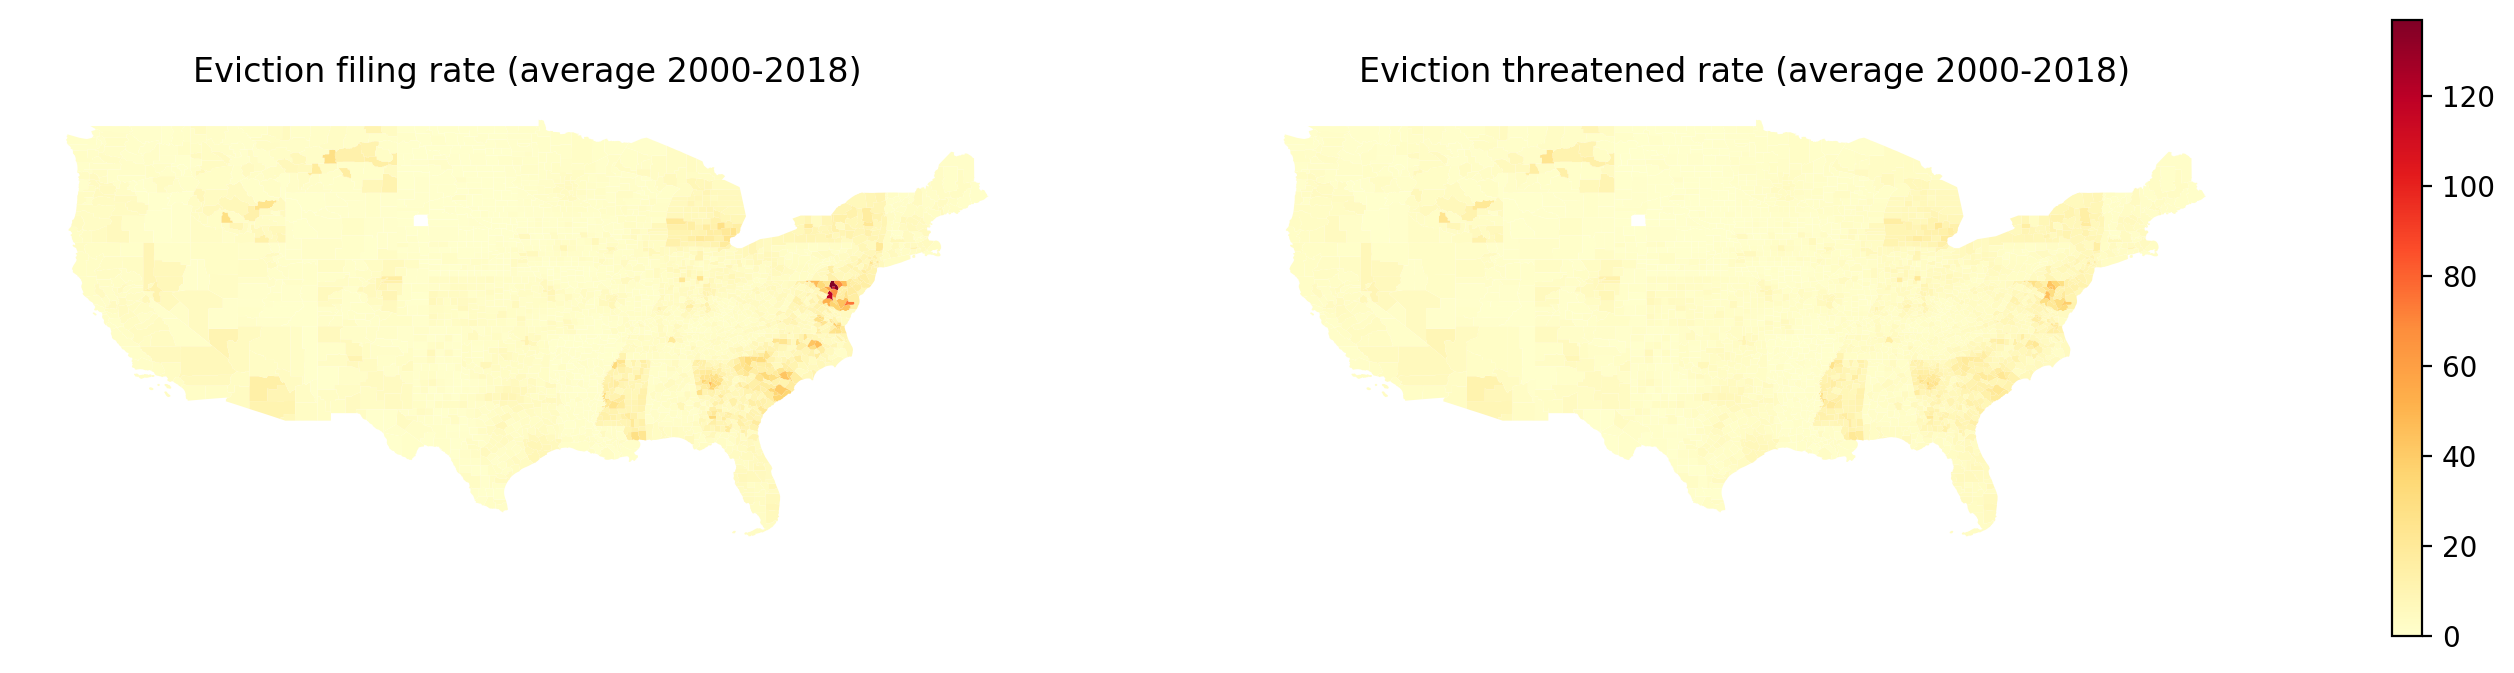

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
# filter out hawaii and alaska for visualization
state_filter = ~gdf_eviction_filings_avg.STATEFP.isin(["15", "02"])
gdf_eviction_filings_avg[state_filter].plot(
    column="filing_rate", ax=axes[0], vmin=0, vmax=137, cmap="YlOrRd", legend=False
)
gdf_eviction_filings_avg[state_filter].plot(
    column="threatened_rate", ax=axes[1], vmin=0, vmax=137, cmap="YlOrRd", legend=False
)
axes[0].set_title("Eviction filing rate (average 2000-2018)")
axes[1].set_title("Eviction threatened rate (average 2000-2018)")
axes[0].set_axis_off()
axes[1].set_axis_off()

# assume it's the first (and only) mappable
patch_col = axes[0].collections[0]
cb = fig.colorbar(patch_col, ax=axes, shrink=0.5)

What area had the highest filing rate (and is colored in a dark red in the mid-Atlantic region)?

In [ ]:
gdf_eviction_filings_avg[
    gdf_eviction_filings_avg["filing_rate"]
    == gdf_eviction_filings_avg["filing_rate"].max()
]

STATEFP COUNTYFP       NAME          NAMELSAD  \
county_fips_full                                                 
24005                 24      005  Baltimore  Baltimore County   

                                                           geometry  \
county_fips_full                                                      
24005             POLYGON ((-76.8873 39.4405, -76.88732 39.44054...   

                  filing_rate  threatened_rate  
county_fips_full                                
24005               136.00706        43.924319

We can also look at some of the counties with eviction filing rates > 99th percentile.

In [ ]:
gdf_eviction_filings_avg[
    gdf_eviction_filings_avg["filing_rate"]
    >= gdf_eviction_filings_avg["filing_rate"].quantile(0.99)
].sort_values("filing_rate", ascending=False)

STATEFP COUNTYFP             NAME                NAMELSAD  \
county_fips_full                                                             
24005                 24      005        Baltimore        Baltimore County   
24033                 24      033  Prince George's  Prince George's County   
24510                 24      510        Baltimore          Baltimore city   
24045                 24      045         Wicomico         Wicomico County   
24025                 24      025          Harford          Harford County   
24003                 24      003     Anne Arundel     Anne Arundel County   
24027                 24      027           Howard           Howard County   
24017                 24      017          Charles          Charles County   
13063                 13      063          Clayton          Clayton County   
24043                 24      043       Washington       Washington County   
37065                 37      065        Edgecombe        Edgecombe County   
24015                 24      015            Cecil            Cecil County   
24019                 24      019       Dorchester       Dorchester County   
24039                 24      039         Somerset         Somerset County   
51830                 51      830     Williamsburg       Williamsburg city   
51730                 51      730       Petersburg         Petersburg city   
37127                 37      127             Nash             Nash County   
45041                 45      041         Florence         Florence County   
51685                 51      685    Manassas Park      Manassas Park city   
45015                 45      015         Berkeley         Berkeley County   
51700                 51      700     Newport News       Newport News city   
24031                 24      031       Montgomery       Montgomery County   
51760                 51      760         Richmond           Richmond city   
24037                 24      037       St. Mary's       St. Mary's County   
51650                 51      650          Hampton            Hampton city   
45067                 45      067           Marion           Marion County   
51580                 51      580        Covington          Covington city   
13255                 13      255         Spalding         Spalding County   
13151                 13      151            Henry            Henry County   
13097                 13      097          Douglas          Douglas County   
45019                 45      019       Charleston       Charleston County   
51678                 51      678        Lexington          Lexington city   

                                                           geometry  \
county_fips_full                                                      
24005             POLYGON ((-76.8873 39.4405, -76.88732 39.44054...   
24033             POLYGON ((-76.95884 38.93159, -76.95898 38.931...   
24510             POLYGON ((-76.71151 39.36622, -76.71151 39.366...   
24045             POLYGON ((-75.8393 38.38877, -75.8424 38.39308...   
24025             POLYGON ((-76.45929 39.50719, -76.45944 39.507...   
24003             POLYGON ((-76.81615 39.12143, -76.81603 39.121...   
24027             POLYGON ((-77.041 39.23419, -77.04119 39.2344,...   
24017             POLYGON ((-77.2557 38.56332, -77.25505 38.5652...   
13063             POLYGON ((-84.45856 33.59444, -84.45861 33.595...   
24043             POLYGON ((-77.84686 39.60696, -77.84688 39.606...   
37065             POLYGON ((-77.81659 35.89121, -77.81616 35.892...   
24015             POLYGON ((-75.93711 39.72188, -75.93703 39.721...   
24019             POLYGON ((-75.97055 38.63702, -75.9652 38.6410...   
24039             POLYGON ((-76.01217 38.15512, -75.99966 38.16,...   
51830             POLYGON ((-76.74296 37.27542, -76.74296 37.275...   
51730             POLYGON ((-77.45492 37.18762, -77.45338 37.188...   
37127             POLYGON ((-78.122 36.03048, -78.12141 36.03136...   
45041          

And we can compute the difference in filing and threatened rates difference between 2018 and 2000, to find out what counties experienced the greatest change in their filing rates over time.

In [ ]:
df_eviction_prev.set_index("FIPS_county", inplace=True)
df_eviction_prev_wide = df_eviction_prev[
    df_eviction_prev["year"].isin([2000, 2018])
].pivot(columns="year", values=["threatened_rate", "filing_rate"])
df_eviction_prev_wide.columns = [
    a[0] + "_" + str(a[1]) for a in df_eviction_prev_wide.columns.to_flat_index()
]
df_eviction_prev_wide["filing_rate_diff"] = (
    df_eviction_prev_wide["filing_rate_2018"]
    - df_eviction_prev_wide["filing_rate_2000"]
)
df_eviction_prev_wide["threatened_rate_diff"] = (
    df_eviction_prev_wide["threatened_rate_2018"]
    - df_eviction_prev_wide["threatened_rate_2000"]
)

gdf_eviction_filings_diff = gdf_counties.join(df_eviction_prev_wide)
gdf_eviction_filings_diff.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME  \
county_fips_full                                                
31039                 31      039  00835841  31039     Cuming   
53069                 53      069  01513275  53069  Wahkiakum   
35011                 35      011  00933054  35011    De Baca   
31109                 31      109  00835876  31109  Lancaster   
31129                 31      129  00835886  31129   Nuckolls   

                          NAMELSAD LSAD CLASSFP  MTFCC CSAFP  ...    AWATER  \
county_fips_full                                              ...             
31039                Cuming County   06      H1  G4020  None  ...  10690952   
53069             Wahkiakum County   06      H1  G4020  None  ...  61588406   
35011               De Baca County   06      H1  G4020  None  ...  29089486   
31109             Lancaster County   06      H1  G4020   339  ...  22832516   
31129              Nuckolls County   06      H1  G4020  None  ...   1718484   

                     INTPTLAT      INTPTLON  \
county_fips_full                              
31039             +41.9158651  -096.7885168   
53069             +46.2946377  -123.4244583   
35011             +34.3592729  -104.3686961   
31109             +40.7835474  -096.6886584   
31129             +40.1764918  -098.0468422   

                                                           geometry  \
county_fips_full                                                      
31039             POLYGON ((-97.01952 42.0041, -97.01952 42.0049...   
53069             POLYGON ((-123.43639 46.2382, -123.44759 46.24...   
35011             POLYGON ((-104.56739 33.99757, -104.56772 33.9...   
31109             POLYGON ((-96.91075 40.78494, -96.91075 40.790...   
31129             POLYGON ((-98.27367 40.0894, -98.27367 40.0894...   

                  threatened_rate_2000 threatened_rate_2018 filing_rate_2000  \
county_fips_full                                                               
31039                         0.177148             0.424448         0.177148   
53069                         0.949367             1.818182         1.265823   
35011                         1.477833             2.429150         1.477833   
31109                         3.260454             3.390461         3.495165   
31129                         0.000000             0.179856         0.000000   

                 filing_rate_2018  filing_rate_diff  threatened_rate_diff  
county_fips_full                                                           
31039                    0.424448          0.247300              0.247300  
53069                    1.818182          0.552359              0.868815  
35011                    2.429150          0.951317              0.951317  
31109                    3.643536          0.148371              0.130008  
31129                    0.179856          0.179856              0.179856  

[5 rows x 24 columns]

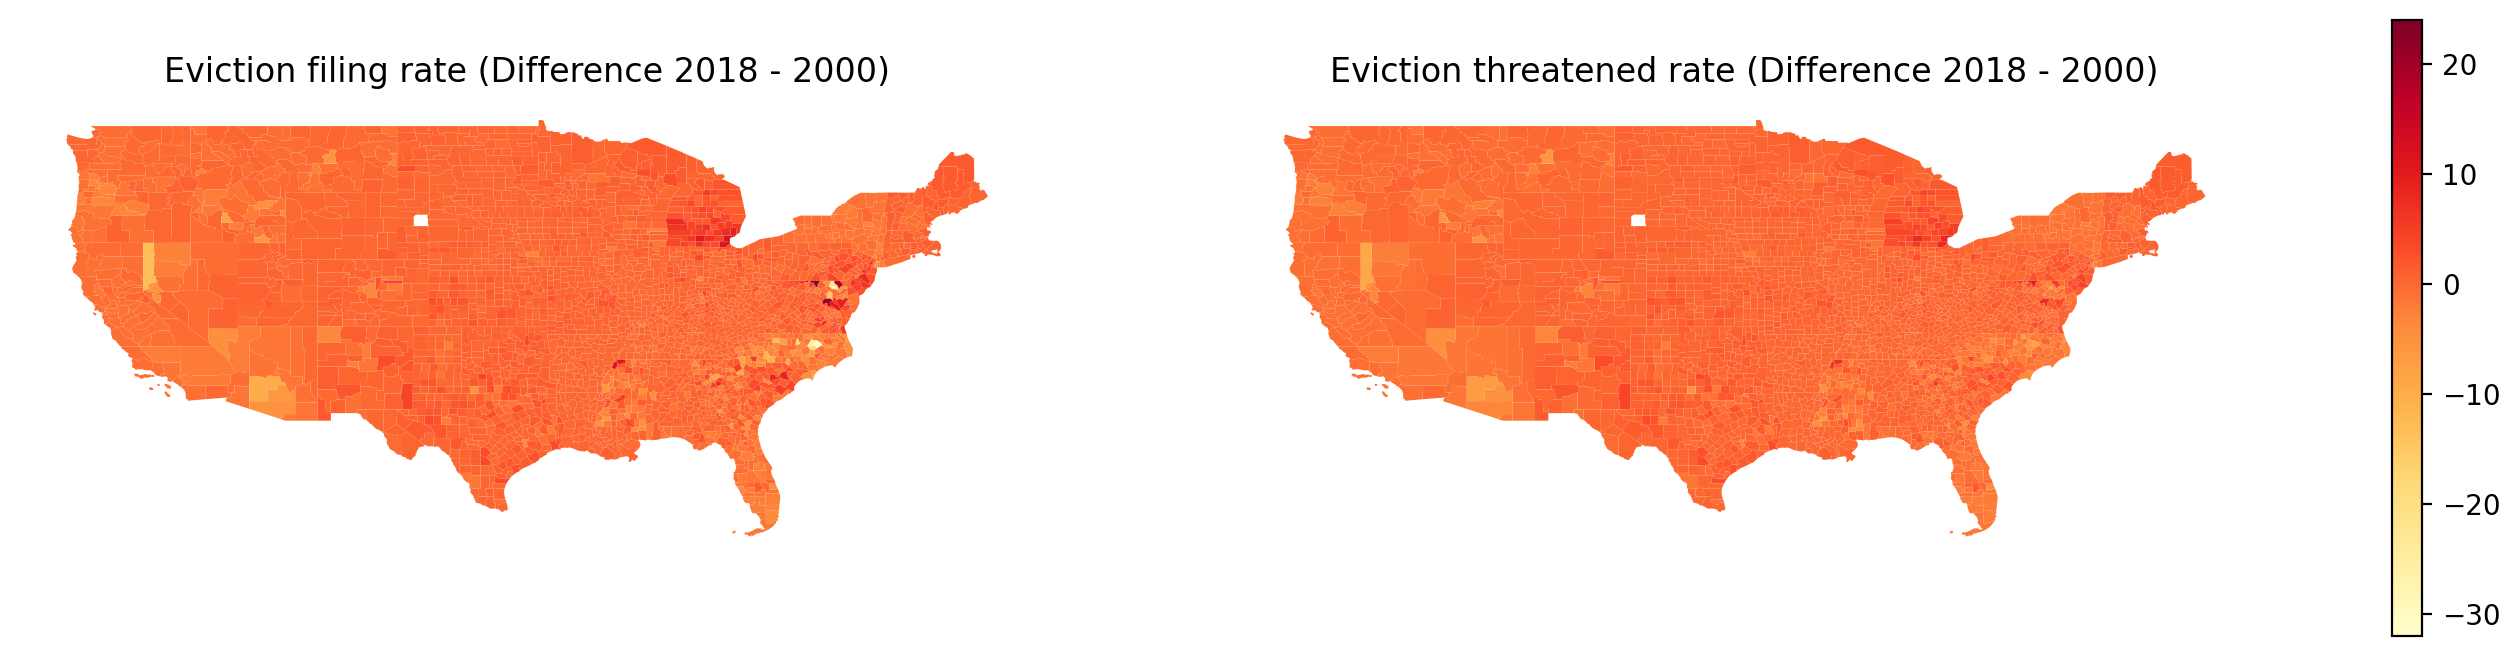

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
# filter out hawaii and alaska for visualization
state_filter = ~gdf_eviction_filings_diff.STATEFP.isin(["15", "02"])
gdf_eviction_filings_diff[state_filter].plot(
    column="filing_rate_diff",
    ax=axes[0],
    vmin=-32,
    vmax=24,
    cmap="YlOrRd",
    legend=False,
)
gdf_eviction_filings_diff[state_filter].plot(
    column="threatened_rate_diff",
    ax=axes[1],
    vmin=-32,
    vmax=24,
    cmap="YlOrRd",
    legend=False,
)
axes[0].set_title("Eviction filing rate (Difference 2018 - 2000)")
axes[1].set_title("Eviction threatened rate (Difference 2018 - 2000)")
axes[0].set_axis_off()
axes[1].set_axis_off()

# assume it's the first (and only) mappable
patch_col = axes[0].collections[0]
cb = fig.colorbar(patch_col, ax=axes, shrink=0.5)

Now we'll explore the proprietary data. The Eviction Lab shares this data on their map, but notes that it has limited coverage and there may be data quality issues. Additionally, these rates have already been produced without denominators, so we won't have to create them ourselves.

In [ ]:
df_proprietary = pd.read_csv(
    "https://eviction-lab-data-downloads.s3.amazonaws.com/estimating-eviction-prevalance-across-us/county_proprietary_2000_2018.csv"
)
df_proprietary.head()

id            name parent_location  year      type  filings  filing_rate  \
0  1001  Autauga County         Alabama  2000  observed     57.0         1.85   
1  1001  Autauga County         Alabama  2001  observed     84.0         2.73   
2  1001  Autauga County         Alabama  2002  observed    100.0         3.25   
3  1001  Autauga County         Alabama  2003  observed    102.0         3.32   
4  1001  Autauga County         Alabama  2004  observed     19.0         0.62   

   threatened  threatened_rate  judgements  judgement_rate  
0        54.0             1.76        35.0            1.14  
1        83.0             2.70        35.0            1.14  
2        97.0             3.16        20.0            0.65  
3        90.0             2.93        12.0            0.39  
4        19.0             0.62        12.0            0.39

In [ ]:
df_proprietary_avg = df_proprietary.groupby(["id"])[
    ["filing_rate", "threatened_rate", "judgement_rate"]
].mean()
df_proprietary_avg.head()

filing_rate  threatened_rate  judgement_rate
id                                                
1001     2.351053         2.228421        1.226316
1003     3.085789         2.992632        1.646842
1005     0.781053         0.770000        0.416316
1007     0.995789         0.979474        0.537895
1009     1.448947         1.424737        1.033158

In [ ]:
gdf_proprietary_filings = gdf_counties.join(df_proprietary_avg, how="left")

In [ ]:
gdf_proprietary_filings.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'filing_rate',
       'threatened_rate', 'judgement_rate'],
      dtype='object')

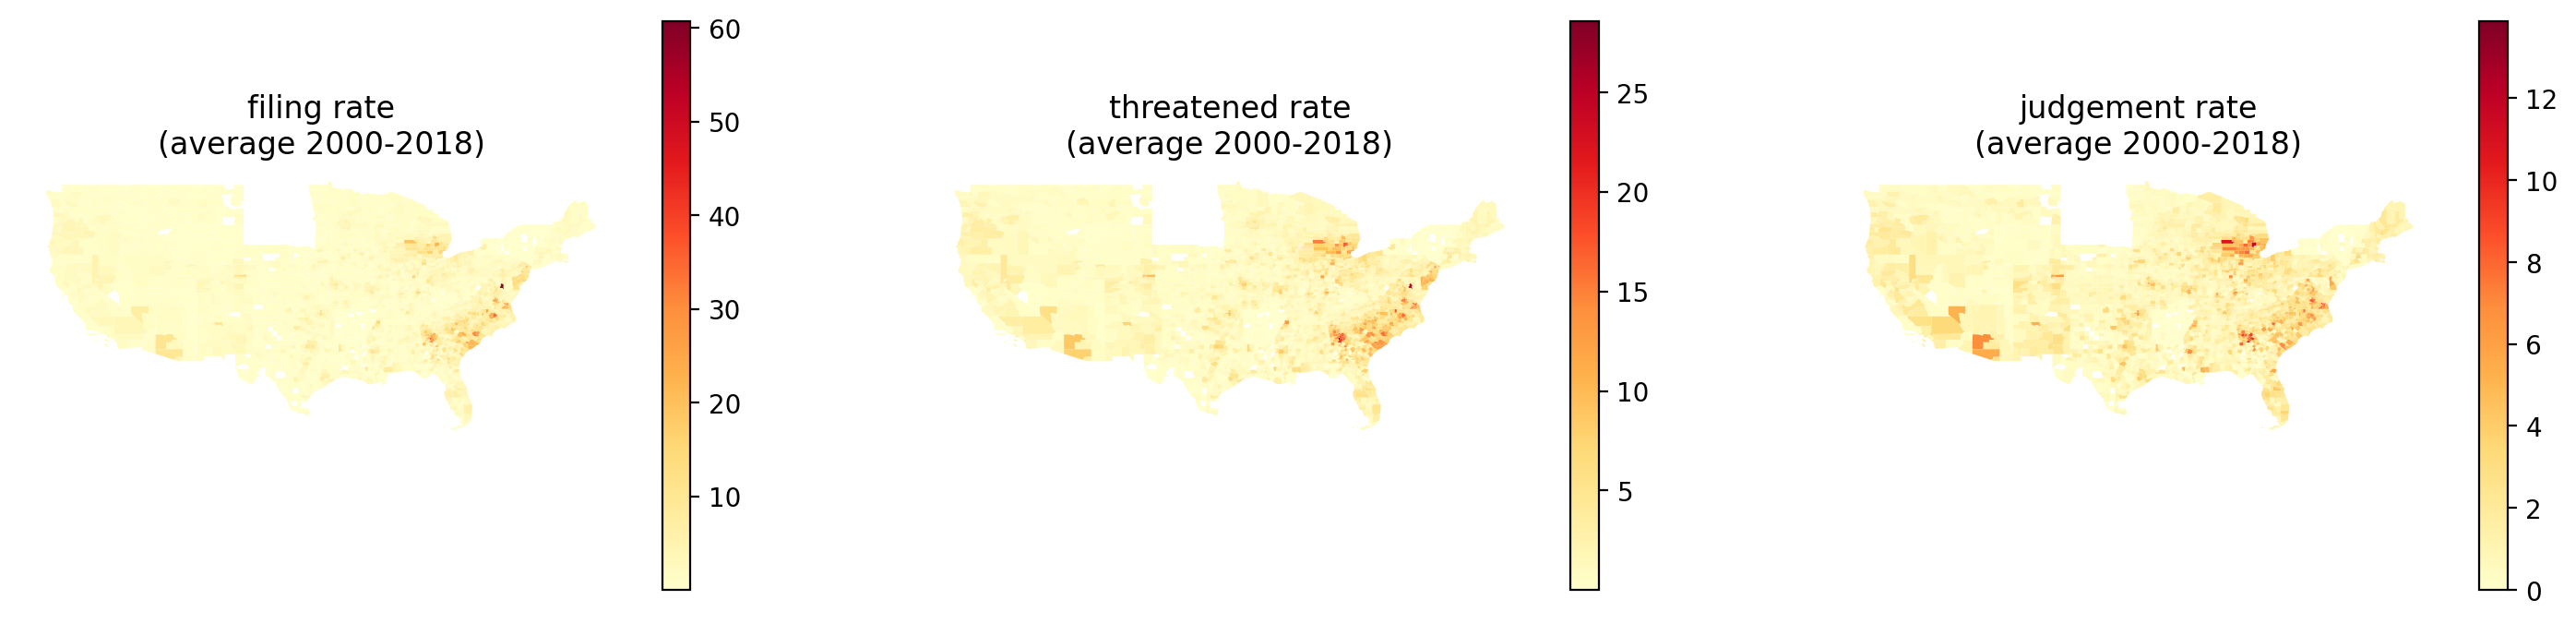

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
# filter out hawaii and alaska for visualization
for i, col in enumerate(["filing_rate", "threatened_rate", "judgement_rate"]):
    state_filter = ~gdf_proprietary_filings.STATEFP.isin(["15", "02"])
    gdf_proprietary_filings[state_filter].plot(
        column=col,
        ax=axes[i],
        cmap="YlOrRd",
        legend=True,
        legend_kwds={"shrink": 0.5},
    )

    axes[i].set_title(f"{col.replace('_',' ')}\n(average 2000-2018)")
    axes[i].set_axis_off()

Interesting, all of the data for North Dakota is not available!

Let's try comparing the modeled data to the proprietary data. It looks like the proprietary data might be undercounting the eviction filing rates and threatened rates.

In [ ]:
df_eviction_mgd = df_eviction_prev.reset_index().merge(
    df_proprietary,
    left_on=["FIPS_county", "year"],
    right_on=["id", "year"],
    suffixes=["_modeled", "_proprietary"],
)

For example, what's happening in Baltimore county?

In [ ]:
df_eviction_mgd[df_eviction_mgd["FIPS_county"] == 24005][
    ["year", "filing_rate_modeled", "filing_rate_proprietary"]
]

year  filing_rate_modeled  filing_rate_proprietary
22724  2000           121.373512                     0.03
22725  2001           118.785111                     0.19
22726  2002           125.663771                     0.02
22727  2003           122.091880                     0.02
22728  2004           123.634952                     0.04
22729  2005           125.206232                     0.35
22730  2006           131.876556                     0.63
22731  2007           140.623602                     2.02
22732  2008           141.270577                    71.71
22733  2009           154.618193                    21.37
22734  2010           152.996842                     0.50
22735  2011           143.349094                     0.51
22736  2012           149.131072                     0.49
22737  2013           148.937600                     0.53
22738  2014           142.774334                     0.47
22739  2015           144.284317                     0.04
22740  2016           147.062861                     0.04
22741  2017           151.670335                     0.03
22742  2018            98.783299                     0.03

In [ ]:
df_eviction_mgd[df_eviction_mgd["FIPS_county"] == 24005][
    ["year", "threatened_rate_modeled", "threatened_rate_proprietary"]
]

year  threatened_rate_modeled  threatened_rate_proprietary
22724  2000                39.097412                         0.03
22725  2001                36.800465                         0.18
22726  2002                39.235539                         0.02
22727  2003                39.196403                         0.02
22728  2004                43.462503                         0.04
22729  2005                46.355005                         0.33
22730  2006                47.269768                         0.58
22731  2007                46.493822                         1.97
22732  2008                46.983345                        22.98
22733  2009                47.646106                        10.58
22734  2010                48.978544                         0.48
22735  2011                46.926642                         0.48
22736  2012                48.142753                         0.47
22737  2013                47.304046                         0.49
22738  2014                45.143977                         0.45
22739  2015                43.416982                         0.04
22740  2016                42.668879                         0.03
22741  2017                43.659065                         0.03
22742  2018                35.780808                         0.03

This is a **huge** undercount!

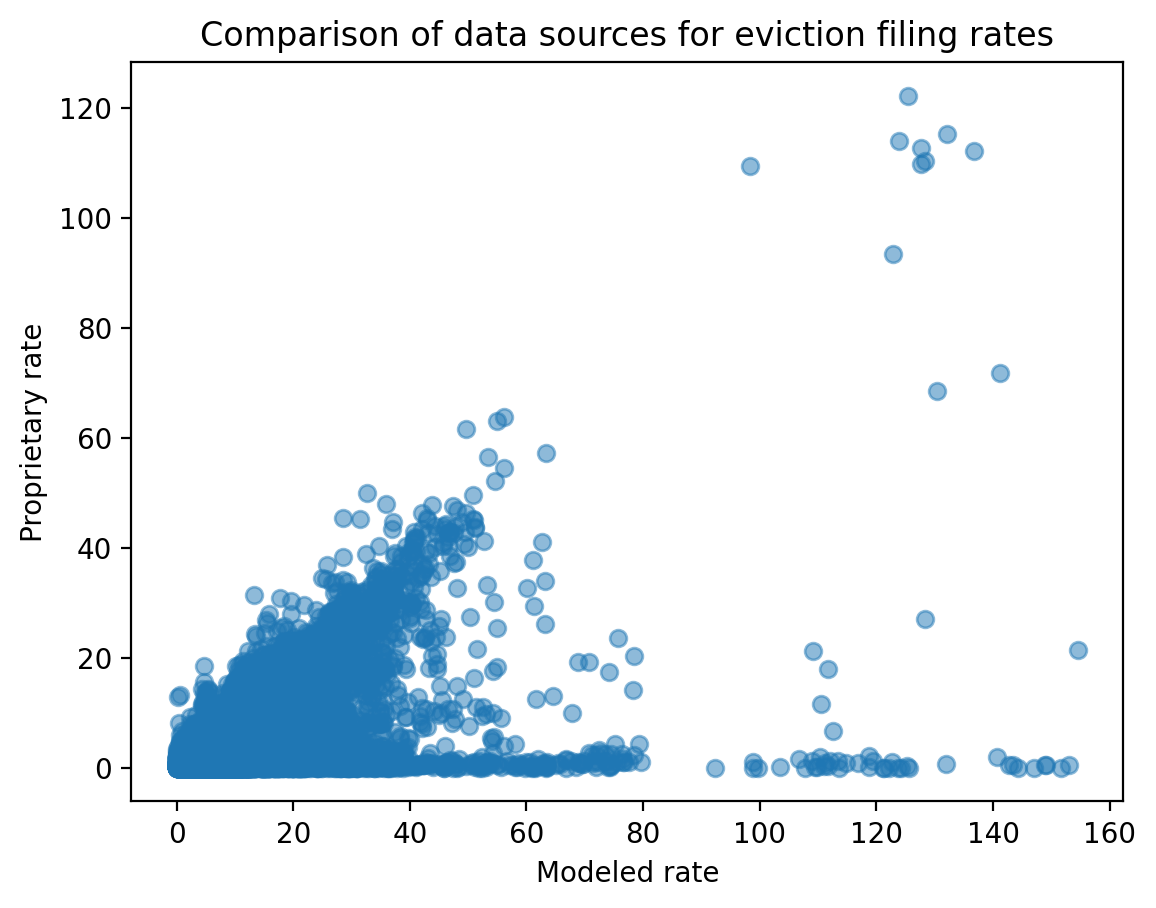

In [ ]:
plt.scatter(
    df_eviction_mgd["filing_rate_modeled"],
    df_eviction_mgd["filing_rate_proprietary"],
    alpha=0.5,
)
plt.xlabel("Modeled rate")
plt.ylabel("Proprietary rate")
plt.title("Comparison of data sources for eviction filing rates")
plt.show()

## Comparison to Census Data

Let's load some county level ACS data.

In [ ]:
acs_cols = [
    "B02001_001E",
    "B02001_002E",
    "B02001_003E",
    "B02001_004E",
    "B02001_005E",
    "B02001_006E",
    "B02001_007E",
    "B02001_008E",
    "B03002_012E",
    "B25038_001E",
    "B25038_009E",
    "B25031_001E",
]
acs_colnames = [
    "totalpop",
    "white",
    "black",
    "aian",
    "asian",
    "nhpi",
    "other",
    "multi",
    "hispanic_latino",
    "totalhh",
    "renters",
    "median_gross_rent",
]

In [ ]:
county_acs_df = pd.DataFrame(
    census.acs5.get(
        tuple(acs_cols),
        geo={
            "for": "county:*",
            "in": "state:*",
        },
        year=2018,
    )
)

In [ ]:
county_acs_df_clean = county_acs_df.rename(
    columns={x: y for x, y in zip(acs_cols, acs_colnames)}
)
county_acs_df_clean["GEOID10"] = (
    county_acs_df_clean["state"] + county_acs_df_clean["county"]
).astype(int)
county_acs_df_clean.set_index("GEOID10", inplace=True)
county_acs_df_clean.head()

totalpop    white  black   aian  asian  nhpi  other  multi  \
GEOID10                                                               
30061      4211.0   3926.0    3.0  107.0   61.0   0.0    7.0  107.0   
30069       432.0    424.0    0.0    0.0    8.0   0.0    0.0    0.0   
30077      6861.0   6235.0   24.0  301.0   34.0   0.0   12.0  255.0   
30089     11521.0  10630.0   19.0  410.0   59.0   1.0   23.0  379.0   
30109      1175.0   1167.0    0.0    4.0    4.0   0.0    0.0    0.0   

         hispanic_latino  totalhh  renters  median_gross_rent state county  
GEOID10                                                                     
30061               81.0   1699.0    459.0              587.0    30    061  
30069                0.0    187.0     61.0              475.0    30    069  
30077              130.0   2388.0    754.0              623.0    30    077  
30089              327.0   4953.0   1162.0              635.0    30    089  
30109               49.0    497.0    106.0              697.0    30    109

In [ ]:
county_acs_df_clean["renters_pct"] = (
    100 * county_acs_df_clean["renters"] / county_acs_df_clean["totalhh"]
)

race_eth_cols = [
    "white",
    "black",
    "aian",
    "asian",
    "nhpi",
    "other",
    "multi",
    "hispanic_latino",
]
for col in race_eth_cols:
    county_acs_df_clean[col + "_pct"] = (
        100 * county_acs_df_clean[col] / county_acs_df_clean["totalpop"]
    )

Let's merge on the Census ACS data.

In [ ]:
county_acs_df_clean

totalpop     white   black   aian   asian  nhpi   other   multi  \
GEOID10                                                                    
30061      4211.0    3926.0     3.0  107.0    61.0   0.0     7.0   107.0   
30069       432.0     424.0     0.0    0.0     8.0   0.0     0.0     0.0   
30077      6861.0    6235.0    24.0  301.0    34.0   0.0    12.0   255.0   
30089     11521.0   10630.0    19.0  410.0    59.0   1.0    23.0   379.0   
30109      1175.0    1167.0     0.0    4.0     4.0   0.0     0.0     0.0   
...           ...       ...     ...    ...     ...   ...     ...     ...   
55049     23620.0   22817.0   194.0   54.0   166.0  19.0   154.0   216.0   
55089     88284.0   82714.0  1200.0  237.0  1970.0  67.0   580.0  1516.0   
55097     70599.0   65756.0   512.0  262.0  1999.0  11.0   971.0  1088.0   
55105    161769.0  142557.0  7081.0  398.0  1955.0  28.0  4379.0  5371.0   
55119     20356.0   19841.0   101.0   50.0    32.0   0.0    91.0   241.0   

         hispanic_latino  totalhh  ...  county  renters_pct  white_pct  \
GEOID10                            ...                                   
30061               81.0   1699.0  ...     061    27.015892  93.232011   
30069                0.0    187.0  ...     069    32.620321  98.148148   
30077              130.0   2388.0  ...     077    31.574539  90.875966   
30089              327.0   4953.0  ...     089    23.460529  92.266296   
30109               49.0    497.0  ...     109    21.327968  99.319149   
...                  ...      ...  ...     ...          ...        ...   
55049              411.0   9835.0  ...     049    26.273513  96.600339   
55089             2526.0  35625.0  ...     089    24.232982  93.690816   
55097             2224.0  28357.0  ...     097    31.096378  93.140129   
55105            13782.0  64538.0  ...     105    32.044687  88.123806   
55119              404.0   8632.0  ...     119    22.428174  97.470033   

        black_pct  aian_pct  asian_pct  nhpi_pct  other_pct  multi_pct  \
GEOID10                                                                  
30061    0.071242  2.540964   1.448587  0.000000   0.166231   2.540964   
30069    0.000000  0.000000   1.851852  0.000000   0.000000   0.000000   
30077    0.349803  4.387116   0.495555  0.000000   0.174902   3.716659   
30089    0.164916  3.558719   0.512108  0.008680   0.199635   3.289645   
30109    0.000000  0.340426   0.340426  0.000000   0.000000   0.000000   
...           ...       ...        ...       ...        ...        ...   
55049    0.821338  0.228620   0.702794  0.080440   0.651990   0.914479   
55089    1.359250  0.268452   2.231435  0.075891   0.656971   1.717185   
55097    0.725223  0.371110   2.831485  0.015581   1.375374   1.541098   
55105    4.377229  0.246030   1.208513  0.017309   2.706946   3.320166   
55119    0.496168  0.245628   0.157202  0.000000   0.447043   1.183926   

         hispanic_latino_pct  
GEOID10                       
30061               1.923534  
30069               0.000000  
30077               1.894768  
30089               2.838295  
30109               4.170213  
...                      ...  
55049               1.740051  
55089               2.861221  
55097               3.150186  
55105               8.519556  
55119               1.984673  

[3220 rows x 23 columns]

In [ ]:
gdf_eviction_filings_demo = gdf_eviction_filings_avg.join(county_acs_df_clean)

# let's also set sentinel values for median gross rent
gdf_eviction_filings_demo["median_gross_rent"] = np.where(
    gdf_eviction_filings_demo["median_gross_rent"] < 0,
    np.nan,
    gdf_eviction_filings_demo["median_gross_rent"],
)

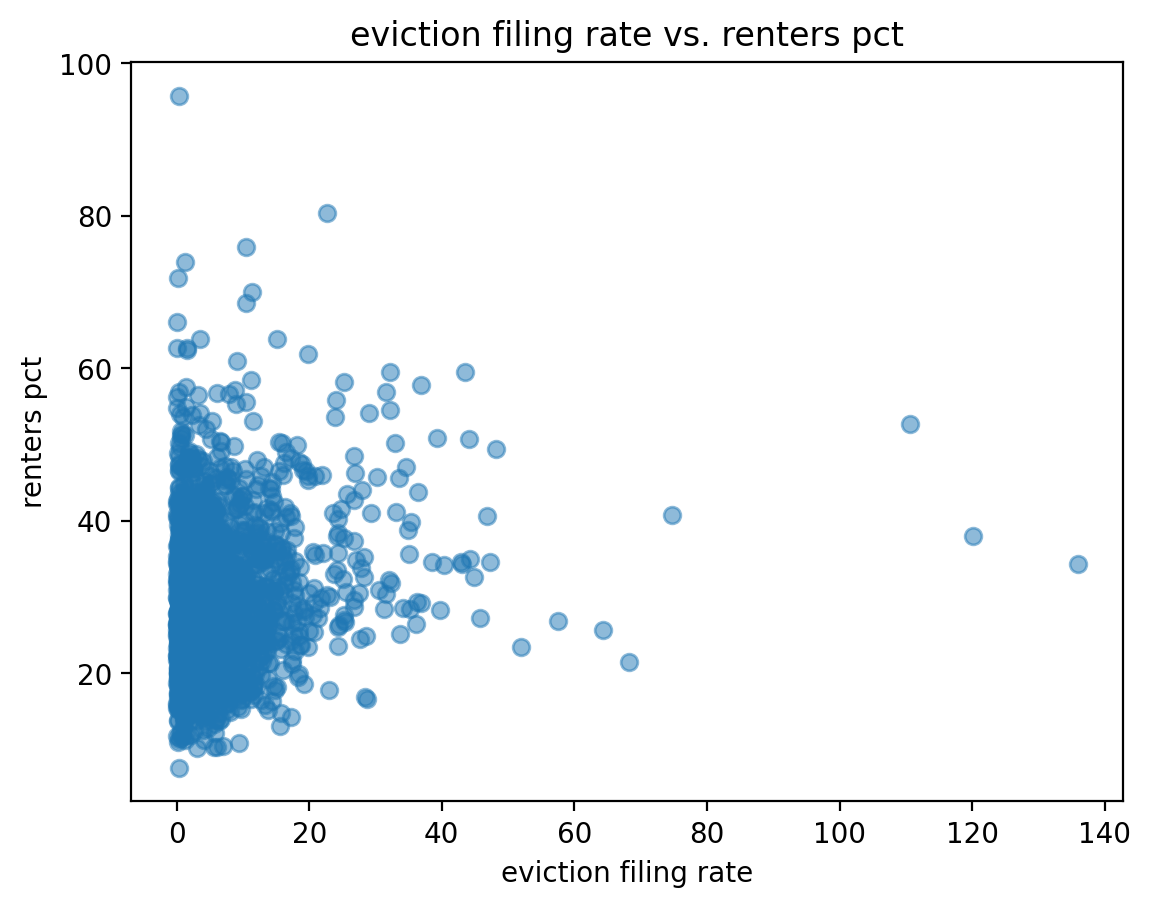

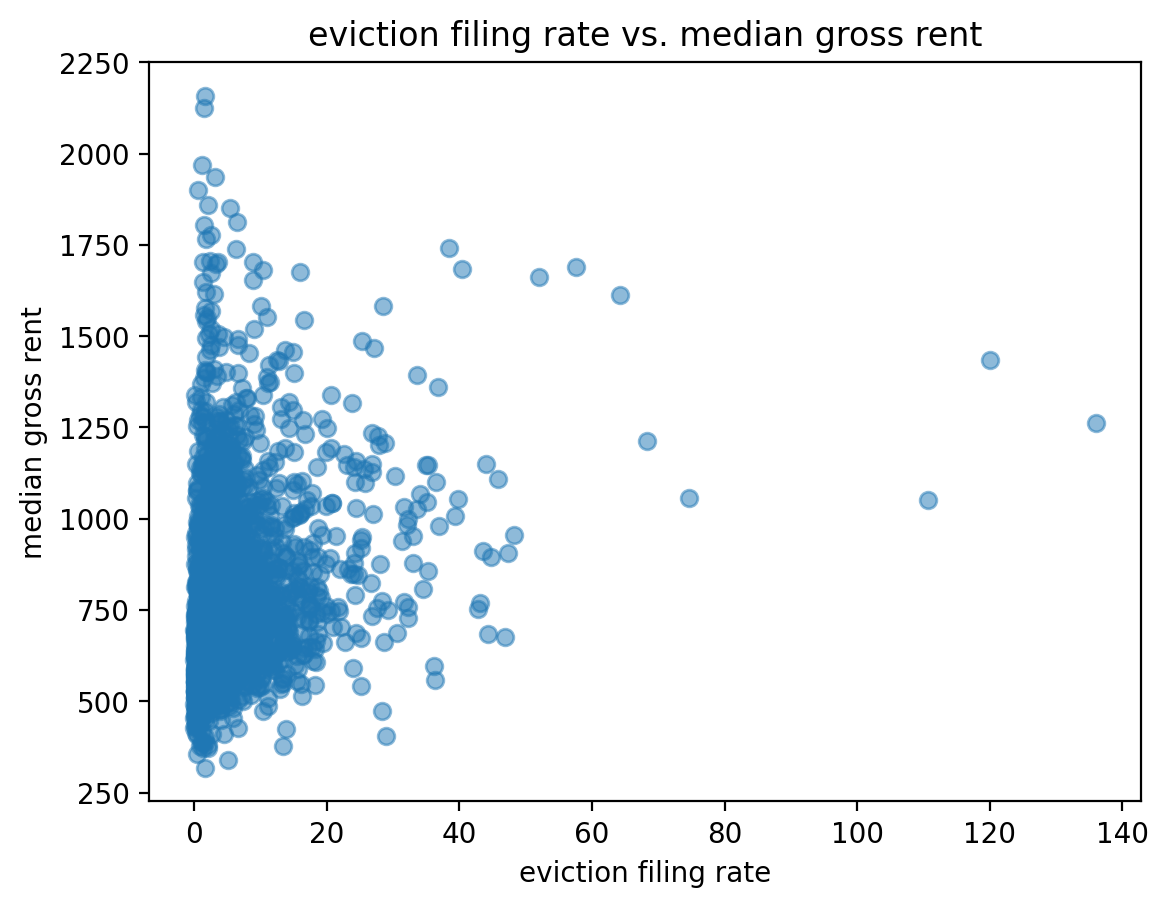

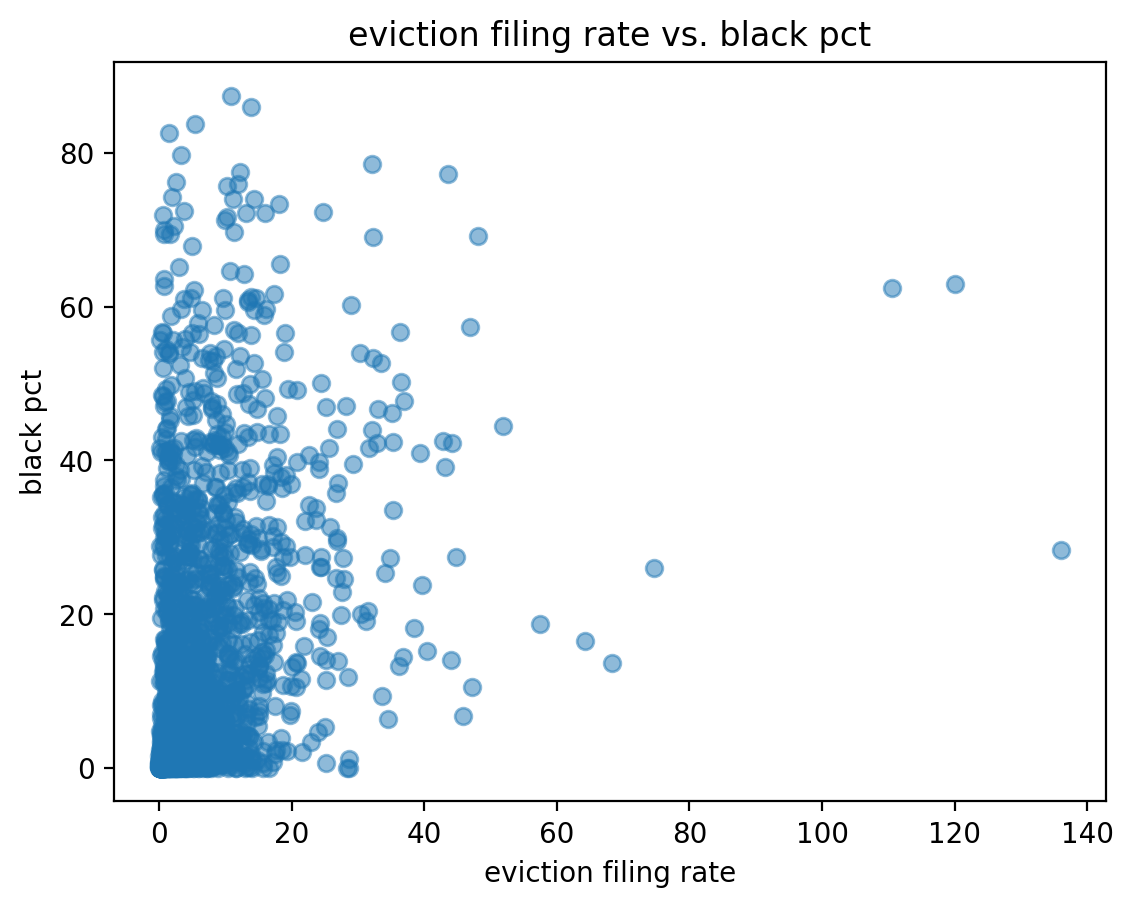

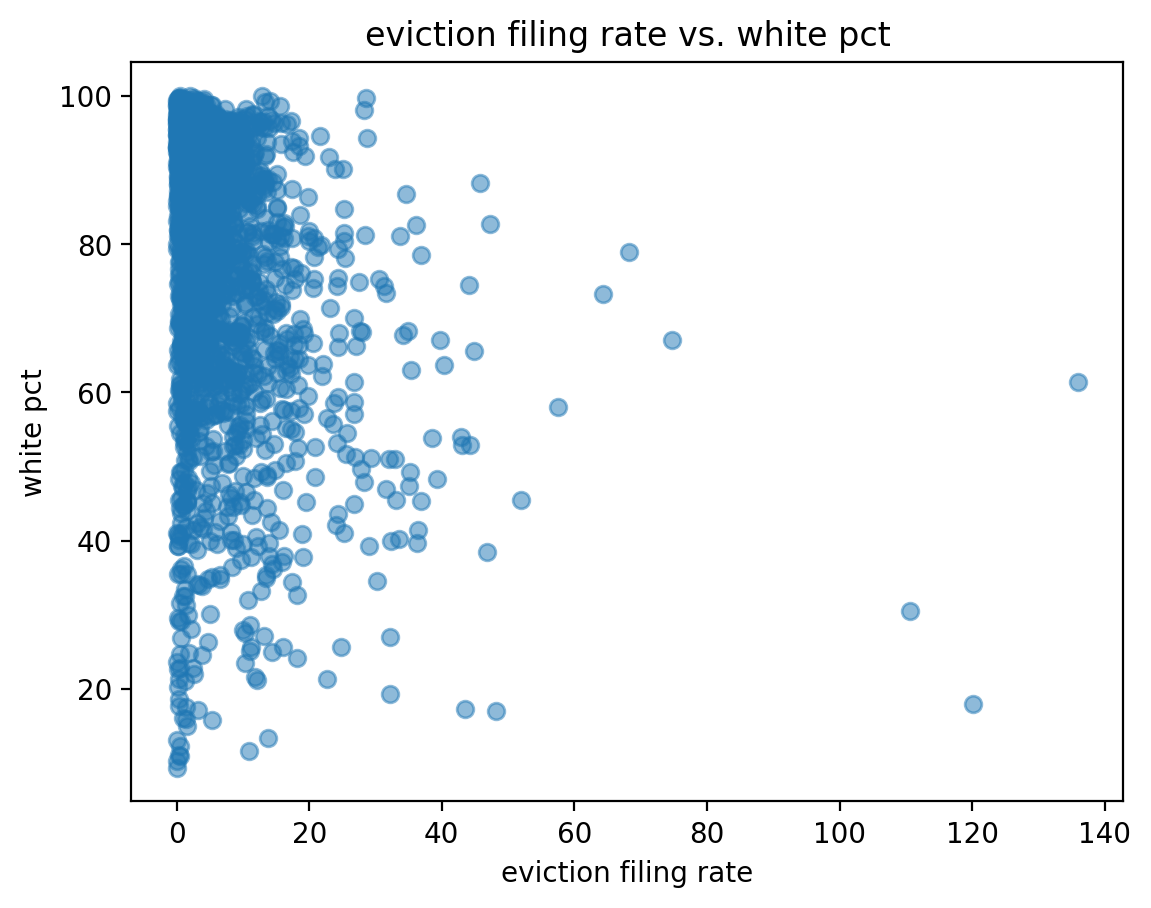

In [ ]:
# just exploring a subset of columns
for col in ["renters_pct", "median_gross_rent", "black_pct", "white_pct"]:
    plt.scatter(
        gdf_eviction_filings_demo["filing_rate"],
        gdf_eviction_filings_demo[col],
        alpha=0.5,
    )
    plt.xlabel("eviction filing rate")
    plt.ylabel(col.replace("_", " "))
    plt.title(f"eviction filing rate vs. {col.replace('_', ' ')}")
    plt.show()

## Eviction Data: NYC Open Data

The Eviction Lab provides a comprehensive resource on evictions, but it's not the only resource on evictions. We can also use local data. For example, New York City publishes an [Open Data set](https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4/about_data) on *executed* evictions. This is building level data on evictions going back to 2017.

Eviction data in general is challenging to obtain and often subject to specific state and local policies. For example, the New York State OCA Data Collective receives housing court filings data from the state Office of Court Administration and shares this with local organizations like the [Housing Data Coalition](https://www.housingdatanyc.org/). The OCA Data Collective includes organizations like the Right to Counsel Coalition, BetaNYC, the Association for Neighborhood and Housing Development, the University Neighborhood Housing Program, and JustFix. It is also affiliated with the Housing Data Coalition (HDC). Together, these groups help to make local, deidentified eviction *filing* data available for New York City, often to support tenant advocacy groups and to fight predatory landlords.

A helpful feature of working with local data from NYC is the use of a borough-block-lot identifier, which uniquely identifies every parcel in the city. This makes it very easy to join tabular data (i.e., eviction data) to geospatial data (i.e., parcel data), and allows us to avoid geocoding ourselves.

We'll first load a subset of [MapPLUTO](https://www.nyc.gov/content/planning/pages/resources?search=pluto#datasets), which is the New York City Department of City Planning's geospatial tax lot data. PLUTO stands for the primary land use tax output.

Note: for ease of loading the data, we'll load only a subset of parcels that we know will join to our eviction data.

In [ ]:
mppluto = gpd.read_file("mappluto_subset.gpkg")
mppluto.head()

BBL OwnerType LandUse  UnitsTotal  UnitsRes  AssessLand  \
0  1.000078e+09      None      04        43.0      42.0   1741500.0   
1  1.000100e+09      None      05        97.0       0.0   6930000.0   
2  1.000118e+09      None      04         4.0       3.0    363150.0   
3  1.000160e+09         X      05         6.0       0.0  52420950.0   
4  1.000200e+09      None      05        71.0       0.0  11340000.0   

     AssessTot    ExemptTot  YearBuilt  \
0    6970950.0          0.0     1880.0   
1   30483900.0          0.0     1930.0   
2    3464190.0          0.0     1900.0   
3  350676450.0  350676450.0     2009.0   
4   32468850.0          0.0     1983.0   

                                            geometry  
0  MULTIPOLYGON (((981311.209 195510.668, 981240....  
1  MULTIPOLYGON (((980867.809 195627.081, 980872....  
2  MULTIPOLYGON (((980911.184 195813.831, 980911....  
3  MULTIPOLYGON (((980392.176 199856.826, 980381....  
4  MULTIPOLYGON (((980678.427 196676.025, 980634....

In [ ]:
mppluto.columns

Index(['BBL', 'OwnerType', 'LandUse', 'UnitsTotal', 'UnitsRes', 'AssessLand',
       'AssessTot', 'ExemptTot', 'YearBuilt', 'geometry'],
      dtype='object')

In [ ]:
mppluto["BBL"].unique().shape, mppluto["BBL"].shape

((40536,), (40536,))

Now we'll load our eviction data from NYC Open Data.

In [ ]:
df_nyc_evictions = pd.read_csv(
    "https://data.cityofnewyork.us/resource/6z8x-wfk4.csv?$limit=1000000"
)

In [ ]:
df_nyc_evictions.shape

(107319, 20)

Now we'll merge the two together. Notice: we can merge on BBL, which is might simpler than geocoding and doing a spatial join.

In [ ]:
nyc_evictions_pluto = mppluto[
    [
        "BBL",
        "OwnerType",
        "LandUse",
        "UnitsTotal",
        "UnitsRes",
        "AssessLand",
        "AssessTot",
        "ExemptTot",
        "YearBuilt",
        "geometry",
    ]
].merge(df_nyc_evictions, left_on="BBL", right_on="bbl")

In [ ]:
# create a version that's point data using centroid
nyc_evictions_pluto_centroid = nyc_evictions_pluto.copy()
nyc_evictions_pluto_centroid["geometry"] = nyc_evictions_pluto_centroid[
    "geometry"
].centroid

In [ ]:
nyc_evictions_pluto_centroid

BBL OwnerType LandUse  UnitsTotal  UnitsRes  AssessLand  \
0      1.000078e+09      None      04        43.0      42.0   1741500.0   
1      1.000078e+09      None      04        43.0      42.0   1741500.0   
2      1.000100e+09      None      05        97.0       0.0   6930000.0   
3      1.000118e+09      None      04         4.0       3.0    363150.0   
4      1.000160e+09         X      05         6.0       0.0  52420950.0   
...             ...       ...     ...         ...       ...         ...   
96669  5.080200e+09      None      01         2.0       2.0      9360.0   
96670  5.080200e+09      None      01         2.0       2.0      9360.0   
96671  5.080280e+09      None      01         2.0       2.0      5280.0   
96672  5.080280e+09      None      01         2.0       2.0      5280.0   
96673  5.080480e+09      None      01         2.0       2.0      6540.0   

         AssessTot    ExemptTot  YearBuilt                       geometry  \
0        6970950.0          0.0     1880.0  POINT (981261.765 195554.133)   
1        6970950.0          0.0     1880.0  POINT (981261.765 195554.133)   
2       30483900.0          0.0     1930.0  POINT (980936.841 195692.534)   
3        3464190.0          0.0     1900.0  POINT (980899.252 195838.209)   
4      350676450.0  350676450.0     2009.0   POINT (980246.708 199670.73)   
...            ...          ...        ...                            ...   
96669      48180.0          0.0     2001.0   POINT (917315.693 127550.54)   
96670      48180.0          0.0     2001.0   POINT (917315.693 127550.54)   
96671      33660.0          0.0     2005.0  POINT (914945.422 125603.509)   
96672      33660.0          0.0     2005.0  POINT (914945.422 125603.509)   
96673      36000.0          0.0     1997.0  POINT (915308.709 125135.319)   

       ...         ejectment  eviction_possession   latitude  longitude  \
0      ...  Not an Ejectment           Possession  40.703611 -74.010932   
1      ...  Not an Ejectment           Possession  40.703611 -74.010932   
2      ...  Not an Ejectment           Possession  40.703954 -74.011592   
3      ...  Not an Ejectment           Possession  40.704034 -74.012068   
4      ...  Not an Ejectment           Possession  40.713846 -74.013812   
...    ...               ...                  ...        ...        ...   
96669  ...  Not an Ejectment           Possession  40.516716 -74.240628   
96670  ...  Not an Ejectment           Possession  40.516716 -74.240628   
96671  ...  Not an Ejectment           Possession  40.511220 -74.248970   
96672  ...  Not an Ejectment           Possession  40.511220 -74.248970   
96673  ...  Not an Ejectment           Possession  40.509789 -74.248069   

      community_board council_district census_tract        bin           bbl  \
0                 1.0              1.0          9.0  1077806.0  1.000078e+09   
1                 1.0              1.0          9.0  1077806.0  1.000078e+09   
2                 1.0              1.0          9.0  1000025.0  1.000100e+09   
3                 1.0              1.0          9.0  1000040.0  1.000118e+09   
4                 1.0              1.0      31703.0  1087239.0  1.000160e+09   
...               ...              ...          ...        ...           ...   
96669             3.0             51.0        248.0  5129474.0  5.080200e+09   
96670             3.0             51.0        248.0  5129474.0  5.080200e+09   
96671             3.0             51.0        248.0  5146458.0  5.080280e+09   
96672             3.0             51.0        248.0  5146458.0  5.080280e+09   
96673             3.0             51.0        248.0  5149821.0  5.080480e+09   

                                          nta  
0           Battery Park City-Lower Manhattan  
1           Battery Park City-Lower Manhattan  
2           Battery Park City-Lower Manhattan  
3           Battery Park City-Lower Manhattan  
4           Battery Park City-Lower Manhattan  
...                                     

In [ ]:
building_eviction_count = (
    nyc_evictions_pluto.value_counts("BBL")
    .reset_index()
    .rename(columns={"count": "total_num_evictions"})
)
nyc_evictions_pluto = nyc_evictions_pluto.merge(building_eviction_count, on="BBL")
nyc_evictions_pluto.head()

BBL OwnerType LandUse  UnitsTotal  UnitsRes  AssessLand  \
0  1.000078e+09      None      04        43.0      42.0   1741500.0   
1  1.000078e+09      None      04        43.0      42.0   1741500.0   
2  1.000100e+09      None      05        97.0       0.0   6930000.0   
3  1.000118e+09      None      04         4.0       3.0    363150.0   
4  1.000160e+09         X      05         6.0       0.0  52420950.0   

     AssessTot    ExemptTot  YearBuilt  \
0    6970950.0          0.0     1880.0   
1    6970950.0          0.0     1880.0   
2   30483900.0          0.0     1930.0   
3    3464190.0          0.0     1900.0   
4  350676450.0  350676450.0     2009.0   

                                            geometry  ... eviction_possession  \
0  MULTIPOLYGON (((981311.209 195510.668, 981240....  ...          Possession   
1  MULTIPOLYGON (((981311.209 195510.668, 981240....  ...          Possession   
2  MULTIPOLYGON (((980867.809 195627.081, 980872....  ...          Possession   
3  MULTIPOLYGON (((980911.184 195813.831, 980911....  ...          Possession   
4  MULTIPOLYGON (((980392.176 199856.826, 980381....  ...          Possession   

    latitude  longitude community_board council_district census_tract  \
0  40.703611 -74.010932             1.0              1.0          9.0   
1  40.703611 -74.010932             1.0              1.0          9.0   
2  40.703954 -74.011592             1.0              1.0          9.0   
3  40.704034 -74.012068             1.0              1.0          9.0   
4  40.713846 -74.013812             1.0              1.0      31703.0   

         bin           bbl                                nta  \
0  1077806.0  1.000078e+09  Battery Park City-Lower Manhattan   
1  1077806.0  1.000078e+09  Battery Park City-Lower Manhattan   
2  1000025.0  1.000100e+09  Battery Park City-Lower Manhattan   
3  1000040.0  1.000118e+09  Battery Park City-Lower Manhattan   
4  1087239.0  1.000160e+09  Battery Park City-Lower Manhattan   

   total_num_evictions  
0                    2  
1                    2  
2                    1  
3                    1  
4                    1  

[5 rows x 31 columns]

In [ ]:
nyc_evictions_pluto[["UnitsRes", "total_num_evictions"]]

UnitsRes  total_num_evictions
0          42.0                    2
1          42.0                    2
2           0.0                    1
3           3.0                    1
4           0.0                    1
...         ...                  ...
96669       2.0                    2
96670       2.0                    2
96671       2.0                    2
96672       2.0                    2
96673       2.0                    1

[96674 rows x 2 columns]

In [ ]:
# let's compute a building level rate
nyc_evictions_pluto["eviction_rate_bldg"] = (
    nyc_evictions_pluto["total_num_evictions"] / nyc_evictions_pluto["UnitsTotal"]
)
nyc_evictions_pluto["eviction_rate_bldg"] = np.where(
    nyc_evictions_pluto["UnitsTotal"] == 0,
    np.nan,
    nyc_evictions_pluto["eviction_rate_bldg"],
)
nyc_evictions_pluto["eviction_rate_bldg"].describe()

count    96424.000000
mean         0.455129
std          2.339168
min          0.000103
25%          0.063145
50%          0.148148
75%          0.368421
max         69.000000
Name: eviction_rate_bldg, dtype: float64

Notice, there are some cases where the total number of units is 0, and so our building eviction rate is missing. It's possible that the number of building units changed over time, or the data has been collected incorrectly. We'll just set these cases to missing, but it's worth investigating for a more in depth analysis.

In [ ]:
print(nyc_evictions_pluto["eviction_rate_bldg"].isna().mean())
nyc_evictions_pluto[nyc_evictions_pluto["eviction_rate_bldg"].isna()]

0.002586010716428409


BBL OwnerType LandUse  UnitsTotal  UnitsRes  AssessLand  \
238    1.000240e+09         P      05         0.0       0.0  20160000.0   
414    1.002000e+09      None      05         0.0       0.0    684000.0   
437    1.001620e+09      None      11         0.0       0.0    445050.0   
1649   1.006320e+09      None      11         0.0       0.0    596250.0   
2013   1.004850e+09      None      10         0.0       0.0    192600.0   
...             ...       ...     ...         ...       ...         ...   
95750  5.001950e+09      None      10         0.0       0.0     50400.0   
95799  5.002290e+09      None      11         0.0       0.0     80550.0   
95991  5.008780e+09      None    None         0.0       0.0    117000.0   
96039  5.011270e+09      None      10         0.0       0.0     11760.0   
96646  5.073110e+09      None      11         0.0       0.0     29250.0   

        AssessTot  ExemptTot  YearBuilt  \
238    96930000.0        0.0     1961.0   
414     1585800.0        0.0     1951.0   
437      445050.0        0.0        0.0   
1649     596250.0        0.0        0.0   
2013     192600.0        0.0        0.0   
...           ...        ...        ...   
95750     50400.0        0.0        0.0   
95799     80550.0        0.0        0.0   
95991    219150.0        0.0        0.0   
96039     13680.0        0.0        0.0   
96646     29250.0        0.0        0.0   

                                                geometry  ...   latitude  \
238    MULTIPOLYGON (((980921.36 196349.247, 981044.0...  ...  40.705351   
414    MULTIPOLYGON (((984734.775 200383.457, 984757....  ...  40.716537   
437    MULTIPOLYGON (((984674.558 199465.527, 984698....  ...  40.713693   
1649   MULTIPOLYGON (((981990.872 206807.111, 981988....  ...  40.734152   
2013   MULTIPOLYGON (((984203.404 202638.627, 984190....  ...  40.722808   
...                                                  ...  ...        ...   
95750  MULTIPOLYGON (((950885.543 171291.553, 950783....  ...  40.637050   
95799  MULTIPOLYGON (((950006.271 168601.619, 949983....  ...  40.629502   
95991  MULTIPOLYGON (((954219.502 158356.556, 954192....  ...  40.601666   
96039  MULTIPOLYGON (((943734.599 169698.832, 943727....  ...  40.632511   
96646  MULTIPOLYGON (((919286.186 135654.909, 919325....  ...  40.539204   

       longitude community_board council_district census_tract        bin  \
238   -74.011502             1.0              1.0          9.0  1000817.0   
414   -73.997947             3.0              1.0         29.0  1002391.0   
437   -73.998092             3.0              1.0         29.0  1001708.0   
1649  -74.008476             2.0              3.0         75.0  1000000.0   
2013  -74.000144             2.0              1.0         49.0  1000000.0   
...          ...             ...              ...          ...        ...   
95750 -74.120695             1.0             49.0      13302.0  5000000.0   
95799 -74.123401             1.0             49.0        141.0  5000000.0   
95991 -74.108682             2.0             50.0        177.0  5154780.0   
96039 -74.146476             1.0             49.0        213.0  5026205.0   
96646 -74.236698             3.0             51.0        226.0  5000000.0   

                bbl                                                nta  \
238    1.000240e+09                  Battery Park City-Lower Manhattan   
414    1.002000e+09                                          Chinatown   
437    1.001620e+09                                          Chinatown   
1649   1.006320e+09                                       West Village   
2013   1.004850e+09             SoHo-TriBeCa-Civic Center-Little Italy   
...             ...                                                ...   
95750  5.001950e+09          West New Brighton-New Brighton-St. George   
95799  5.002290e+09          West New Brighton-New Brighton-St. George   
95991  5.008780e+09  Todt Hill-Emerson Hill-Heartland Village-Light...   
96039  5.011270e+09 

We'll subset to nonmissing eviction rates.

In [ ]:
nyc_evictions_pluto = nyc_evictions_pluto[
    nyc_evictions_pluto["eviction_rate_bldg"].notna()
]

In [ ]:
nyc_evictions_pluto["eviction_rate_bldg"].min(), nyc_evictions_pluto[
    "eviction_rate_bldg"
].max(), nyc_evictions_pluto["eviction_rate_bldg"].quantile(0.95)

(np.float64(0.0001034233116144379),
 np.float64(69.0),
 np.float64(1.3333333333333333))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nyc_evictions_pluto.plot(
    ax=ax,
    column="eviction_rate_bldg",
    vmin=0,
    legend=True,
    cmap="YlOrRd",
    legend_kwds={"shrink": 0.4},
)
ax.set_axis_off()

Let's try visualizing this. We'll drop extreme outliers, and we'll change the size of points based on the eviction rate. We'll also use the building centroid.

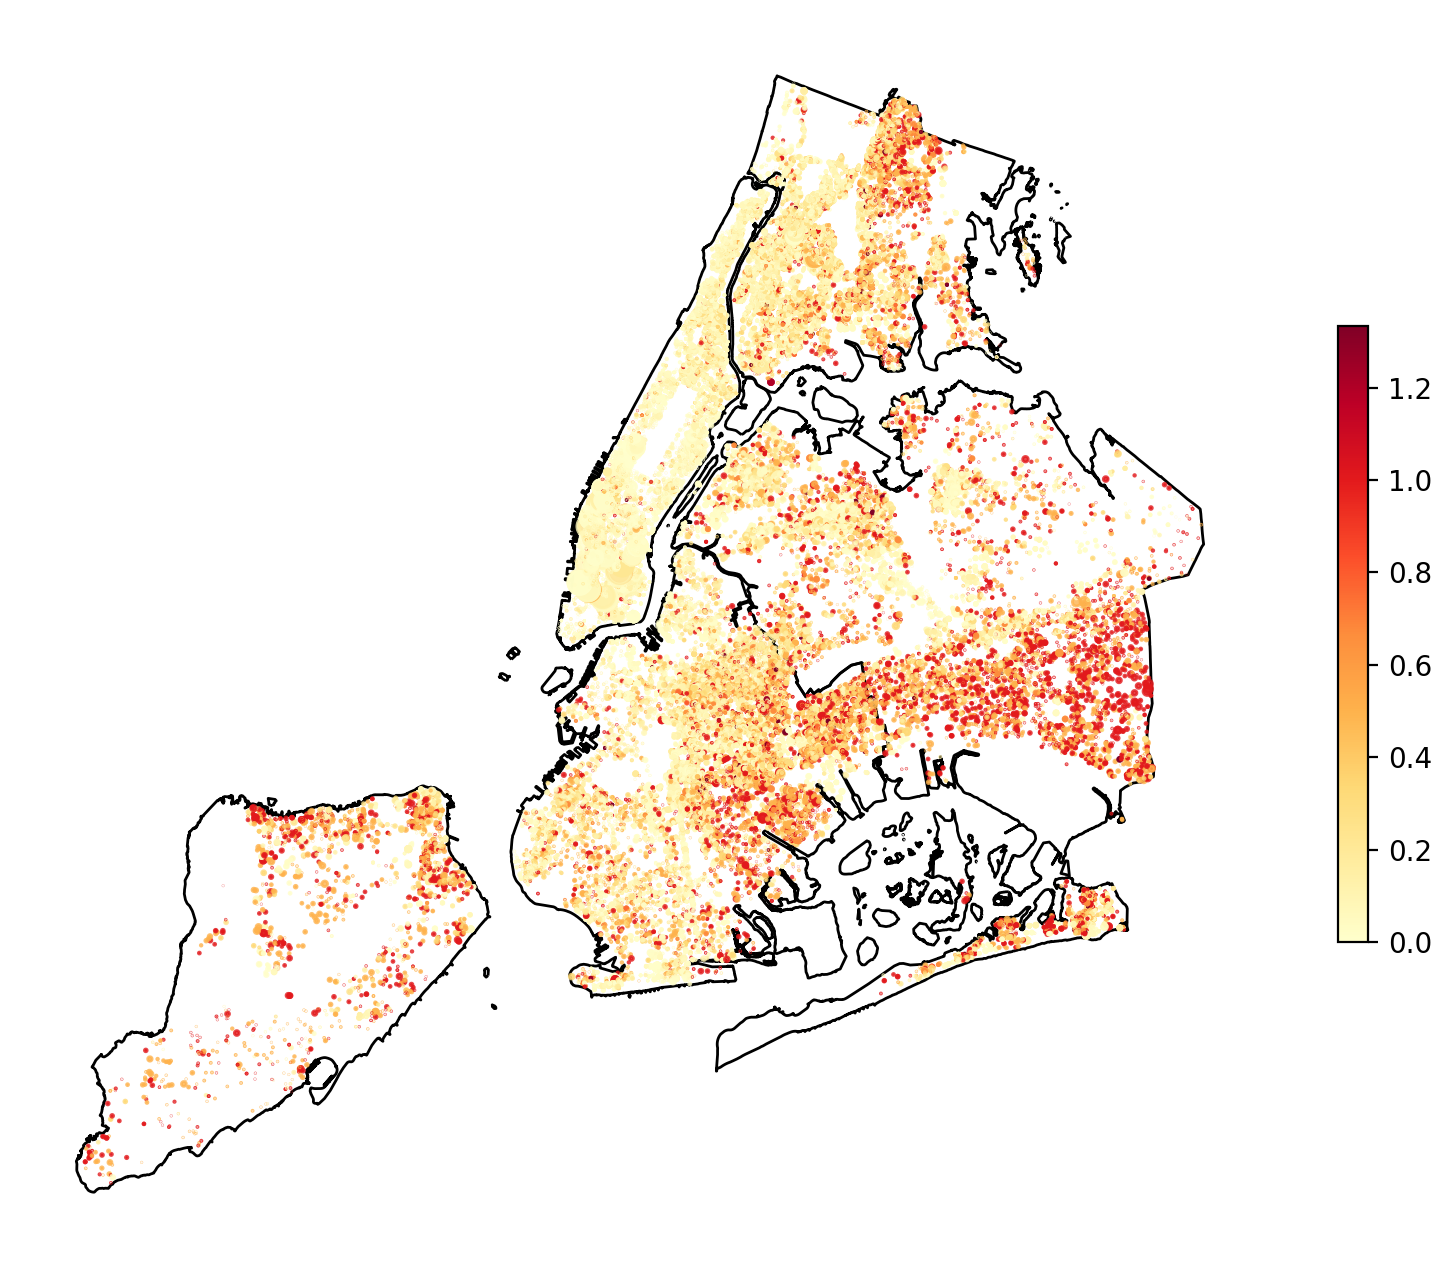

In [ ]:
nyc_evictions_pluto["geometry"] = nyc_evictions_pluto["geometry"].centroid

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
boros = gpd.read_file(
    "https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson"
).to_crs(2263)
ax = boros.plot(ax=ax, facecolor="none")
nyc_evictions_pluto[
    nyc_evictions_pluto["eviction_rate_bldg"]
    <= nyc_evictions_pluto["eviction_rate_bldg"].quantile(0.95)
].plot(
    ax=ax,
    column="eviction_rate_bldg",
    markersize=nyc_evictions_pluto["eviction_rate_bldg"],
    vmin=0,
    alpha=0.8,
    legend=True,
    cmap="YlOrRd",
    legend_kwds={"shrink": 0.4},
)
ax.set_axis_off()

We can also make a heatmap using Folium.

In [ ]:
map = folium.Map(location=[40.7, -73.97], tiles="Cartodb dark_matter", zoom_start=10)
heat_data = [
    [point.xy[1][0], point.xy[0][0]]
    for point in nyc_evictions_pluto_centroid.to_crs(4326).geometry
]

folium.plugins.HeatMap(heat_data, radius=20, blur=20, min_opacity=0.2).add_to(
    map,
)
map